# Optimizing Camera Placement for Emergency Prevention and Response

Scientific mentors: Matteo Vandelli and Daniele Dragoni (Leonardo S.p.a.)

Here we propose a problem of interest in this field: an optimization problem involving the placement of hyperspectral cameras used in the prevention of natural disasters and in emergency response.
The formulation of the problem is a simplified one, which has important connections with real-world scenarios.

Simplifying assumptions are: 
- The field of view of the cameras is isotropic, while in reality it depends on the morphology of the territory.
- The risk of a natural disaster occurring on the territory of choice is homogeneous.

We have $N$ candidate sites and $C$ available antennas (we assume that $C=0$ means no constraint).

The corresponding Ising problem has the following form, in terms of the Ising binary variables $z_i \in \{-1, 1\}$:

\begin{align}
H_C(z) &= \sum\limits_{i<j}^N W_{ij} z_i z_j - \xi \sum\limits_{i=1}^N A_i z_i\\
& \text{s.t.} 
\hspace{1cm}\left\{\begin{matrix}
\sum\limits_{i=1}^N z_i = N - 2C    \hspace{1.5cm}&\text{if $C>0$}\\
\text{none}   &\text{if $C=0$}
\end{matrix}\right.
\end{align}



where 
- $W_{ij}$ is the overlap area between the fields of view of two cameras,
- $A_i$ is the area covered by a camera at site $i$,
- $\xi$ is a positive real number to be suitably tuned.

This problem has been proposed in Ref.[1] in the context of antenna placement.
This "spin ILP" problem can be written in the unconstrained form:
\begin{align}
H_P(z) = H_C(z) + P\left(\sum\limits_{i=1}^N z_i - \delta N\right)^2
\end{align}
where $P \geq 0$ is a penalty term that has to be chosen large enough to obtain a ground state with the correct number of cameras, but not too large otherwise the optimization becomes more complicated. In this case, $P=0$ means that the problem is unconstrained.

Your job is to study the performances of the TN algorithms (variational and/or imaginary-time) for **both** the *constrained* and *unconstrained* cases.


[1] *Evaluating the Practicality of Quantum Optimization Algorithms for Prototypical Industrial Applications*,
M. Vandelli, A. Lignarolo, C. Cavazzoni, D. Dragoni, arXiv:2311.11621 (2023)


In [1]:
# Loading libraries to handle the problem
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.qmc import Sobol
import itertools
import qtealeaves as qtl
from qtealeaves import modeling
from qtealeaves.convergence_parameters import TNConvergenceParameters


In [2]:
# Utility for plotting the antennas
def plot_antennas(df, status, axes=None):
    """
    Function for plotting the cameras with their field of view.
    
    
    Input:
    -----------------------------------------
       df:     pandas Dataframe with cols 
               'id', 'x_loc', 'y_loc', 'radius'
       status: numpy.array describing the status on/off (0/1) of the sites
       axes:   mpl Axes object to add the cameras.
               If None, new Axes object is created. 
               Default: None.
    
    Returns:
    -----------------------------------------
    None
    
    """
    if axes is None:
        figure, axes = plt.subplots()
    for n, row in df.iterrows():
        color = 'g' if int(status[n]) == 0 else 'b'
        alpha = 0.5 if int(status[n]) == 0 else 0.3
        Drawing_colored_circle = plt.Circle(( row.x_loc , row.y_loc ), row.radius, color=color, alpha=alpha)
        axes.set_aspect( 1 )
        axes.add_artist( Drawing_colored_circle )
    # ax = df.plot(x='x_loc', y='y_loc', kind='scatter', s='area', alpha=0.45)
    df.plot(x='x_loc', y='y_loc', kind='scatter', s=10., color='k', ax=axes)
    df[['x_loc','y_loc','id']].apply(lambda x: axes.text(x[0], x[1], int(x[2])),axis=1)
    axes.set_ylabel('Latitude', fontsize=14)
    axes.set_xlabel('Longitude', fontsize=14)

## Generation of the site locations

For the purpose of this Hackathon, the sites will be generate in a quasi-random manner using [Sobol sequencies](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.qmc.Sobol.html). The reason for this choice is that the sample will be evenly distributed in the region, unlike a randomly-generated sample.

Industrial problems usually don't have symmetries so we explicitly avoid them. It would be tempting to choose cameras with the same field of view. However, this will introduce a symmetry which is usually absent in industrial problems: non-overlapping sites would have the same probability of being turned on. We remove this degeneracy by generating the fields of view randomly (but with fixed seed for reproducibility!). The choice below allows to scale the problem with a reasonable overlap as N increases.

We generate here an instance of the problem with $N=16$ sites and $C=8$ cameras.
This size of the problem should be easily solvable by brute-force search.

In [3]:
# number of sites
N = 16

# number of cameras
C = N//2 

# side of the square defining the simplified model
a = 10

# Generate radius of the antennas
np.random.seed = 42
radius = 0.5*a*(1. + np.random.rand(N))/np.sqrt(N)

# Distribute sites uniformly but not symmetrically in the square
m = int(np.ceil(np.log2(N)))
sampler = Sobol(2, scramble=False, optimization='lloyd')
sequence = sampler.random_base2(m=m)

C:\Users\prana\AppData\Local\Temp\ipykernel_24040\894357573.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df[['x_loc','y_loc','id']].apply(lambda x: axes.text(x[0], x[1], int(x[2])),axis=1)


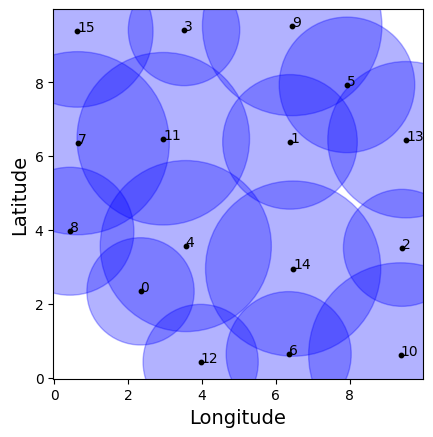

In [23]:
# Save the data of the cameras in a Pandas Dataframe

xs = [a*x[0] for x in sequence][:N]
ys = [a*x[1] for x in sequence][:N]

d = {'id': np.arange(N, dtype=int), 
     'x_loc': xs, 
     'y_loc': ys, 
     'radius': radius,
     'area': np.pi*radius**2}
data = pd.DataFrame(data=d)

# plot the sites
plot_antennas(data, status=np.ones((data.shape[0],)))


Compute the overlap between each pair of sites. This can be done with a simple function, knowing coordinates and radius of each camera, as discussed in [mathworld](https://mathworld.wolfram.com/Circle-CircleIntersection.html) or [stack-exchange](https://math.stackexchange.com/questions/97850/get-the-size-of-an-area-defined-by-2-overlapping-circles).

In [5]:
def circle_overlap(x0, y0, r0, x1, y1, r1):
    """ 
    Function to calculate the overlap between two circles,
    given the coordinates of the center and the radius of each circle.

    
    Input:
    -----------------------------------------
       x0:  float, x-coordinate of first circle
       y0:  float, y-coordinate of first circle
       r0:  float, radius of first circle
       x1:  float, x-coordinate of second circle
       y1:  float, y-coordinate of second circle
       r1:  float, radius of second circle
    
    Returns:
    -----------------------------------------
    float, overlap.
    
    """
    rr0 = r0*r0
    rr1 = r1*r1
    c = np.sqrt((x1-x0)*(x1-x0) + (y1-y0)*(y1-y0))
    if c > r0 + r1:
        return 0.0
    if r0 > r1 + c:
        return np.pi*r1**2
    if r1 > r0 + c:
        return np.pi*r0**2
    phi = (np.arccos((rr0+(c*c)-rr1) / (2*r0*c)))
    theta = (np.arccos((rr1+(c*c)-rr0) / (2*r1*c)))
    overlap = theta*rr1 + phi*rr0 - 0.5*np.sqrt((r0+r1-c) * (r0-r1+c) * (r1-r0+c)*(r1+r0+c))
    return overlap



Build the $W_{ij}$ matrix and the $A_i$, given the previously-generated data for the sites.

In [6]:
def generate_problem(data, xi, normalize=False):
    """ 
    Function to calculate the overlap matrix and the linear term of the Ising model,
    given the problem parameters.

    
    Input:
    -----------------------------------------
        data: pandas.DataFrame,  data of the cameras.
        xi: float, relative multiplier.
        normalize: bool, return normalized terms. Default: False.
    
    Returns:
    -----------------------------------------
    float, overlap.
    
    """
    assert xi >= 0, r"\xi parameters must be non-negative."
    W = np.zeros((data.shape[0], data.shape[0]))
    for n, row1 in data.iterrows():
        for m, row2 in data.iterrows():
            if m == n:
                continue
            W[n, m] = circle_overlap(row1.x_loc, 
                                     row1.y_loc, 
                                     row1.radius,
                                     row2.x_loc,
                                     row2.y_loc,
                                     row2.radius)

    # We define the quantities in the theory
    A = -xi * data['area'].to_numpy()

    ## Normalize the matrices
    if normalize:
        norm = max([np.max(abs(W)), np.max(abs(A))])
        W = W.copy()/norm
        A = A.copy()/norm
    return W, A

## Case 1: unconstrained problem

We create the Ising matrix and linear term of the unconstrained problem.

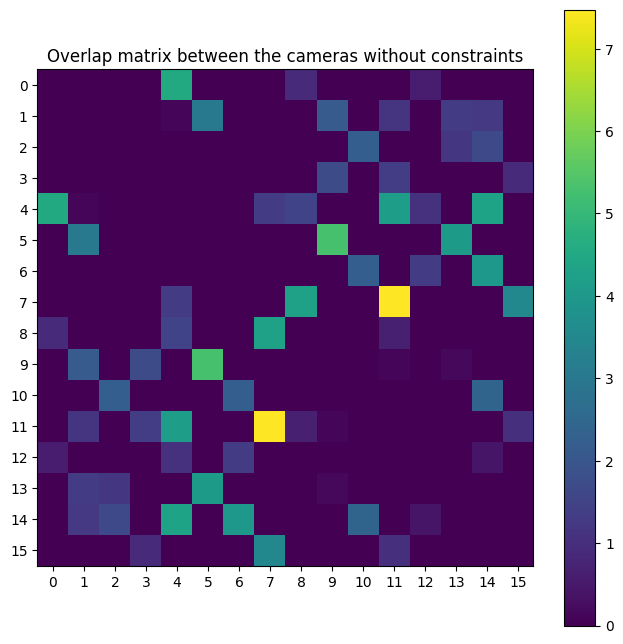

In [7]:
# actual generation of the problem
W, A = generate_problem(data, 1.0, normalize=False)

plt.figure(figsize=(8, 8))
plt.imshow(W)
plt.colorbar()
plt.title("Overlap matrix between the cameras without constraints")
N = W.shape[0]
N_r = np.arange(N)
N_t = [str(i) for i in N_r]
_ = plt.xticks(N_r, N_t)
_ = plt.yticks(N_r, N_t)

## Case 2: Constrained case

We can then add the constrained part as follows.

The soft formulation of the number constraint in the Ising form reads
\begin{align}
       Q_P(x) &= \left(\sum_i x_i - C\right)^2 = \hspace{1cm} \text{(QUBO)} \longrightarrow \text{(Ising)}\\
       H_P(z) &=(\sum_i (1+z_i)/2 - C)^2 = \frac14 (\sum_i (1 + z_i) - 2C )^2 =\\
        &=\frac14 (\sum_i z_i + N_q - 2 C)^2 = \frac14 (\sum_i z_i^2 + 2\sum_{i < j} z_i z_j + \sum_i 2  \, \delta \, N  z_i)\\
        &= \frac14 (N_q + 2\sum_{i < j} z_i z_j + \sum_i 2  \, \delta N \, z_i)
\end{align}

This part must be added to the unconstrained Hamiltonian in the case of constrained calculations.

The function `number_constraint` takes care of this step.

In [8]:
def number_constraint(W, A, C, P, normalize=False):
    """ 
    Function to calculate the overlap matrix and the linear term of the constrained 
    Ising model, given the unconstrained Ising matrix and linear term.

    
    Input:
    -----------------------------------------
       W:           numpy.ndarray, Ising matrix of unconstrained model, shape=(N, N)
       A:           numpy.array, Ising linear term of unconstrained model, shape=(N,)
       C:           int, number of available cameras
       P:           int, penalty factor
       normalize:   bool, normalize the Ising terms? Default: False. 
    
    Returns:
    -----------------------------------------
        W_P:     numpy.ndarray, Ising matrix of constrained model, shape=(N, N)
        A_P:     numpy.array, Ising linear term of constrained model, shape=(N,)
        scaling: float, scaling applied to the matrices (if normalize is False, it is 1.0).
    
    """
    num_sites = W.shape[0]
    assert P >=0, "Penalty must be non-negative"
    assert N > C > 0, "Number of cameras must be in (0, N)"
    W_P = W.copy() + 2 * P*(np.ones((num_sites, num_sites))
                 -np.eye(num_sites))
    A_P = A.copy() + 2 * P * (num_sites - 2*C) * np.ones((num_sites,))
    scaling = 1.0
    if normalize:
        max_w = np.max(W_P)
        max_node = np.max(np.abs(node_weight))
        scaling = max([max_w, max_node])
        W_P *= scaling
        A_P *= scaling
    return W_P, A_P, scaling


In [9]:
W_P, A_P, scaling = number_constraint(W, A, C, P=2.0, normalize=False)

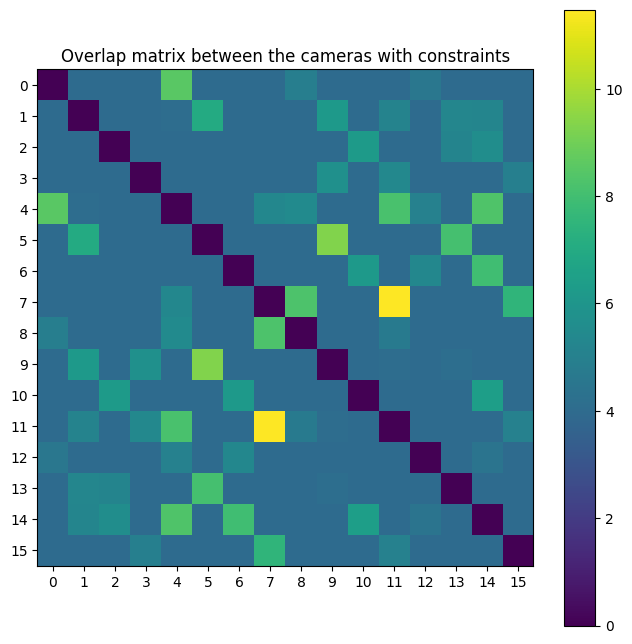

In [10]:
plt.figure(figsize=(8, 8))
plt.imshow(W_P)
plt.colorbar()
plt.title("Overlap matrix between the cameras with constraints")
N = W_P.shape[0]
N_r = np.arange(N)
N_t = [str(i) for i in N_r]
_ = plt.xticks(N_r, N_t)
_ = plt.yticks(N_r, N_t)

In [11]:
# HINT: P=0. generates the unconstrained problem so you can wrap this
# as you like and change only N, P and C

## Comments on the tasks

The tasks for this project are outlined in the README file. Here are a few more hints to solve the problem. Of course, feel free to express your creativity, if you find better performance indicators.


- This project is not devoted to model derivation/setup, but mostly on the analysis of the results. The main focus of this project is to analyse the performance scaling as a function of the dimensionality of the system. A plot of "metric" vs $N$ should be provided for each selected metrics. An estimate of the scaling of the various metrics in the Big-O notation should be provided (polynomial, exponential...?). What are the differences in terms of runtime and accuracy between the constrained and unconstrained cases?


- We start from a small instance with $N=16$, that you should be able to address directly with brute-force search (BF) in a matter of seconds. A problem with $N=32$ should also be solvable with BF, but could require minutes to hours depending on the efficiency/parallelism of your BF code. 


- The TN solver should work up to $N \approx 1000$ qubits. In the current version, the tensor-network solver can handle variables which are powers of 2, so the number of variables should be set to $N = 2^n$. For the purpose of this Hackathon, we suggest to explore powers of two at least up to $N=512$ ($n=9$).


- Imaginary-time and variational solvers have both internal hyper-parameters. Be sure to tune them properly to achieve good convergence!


- If you decide to use a commercial code (CPLEX or GUROBI), you will be able to get the exact solution up to $N=256$.


- If a metric requires the extraction of pseudorandom samples, please provide some estimate of the sampling uncertainty.


### Suggestion of performance metrics

The performance metrics of TN should include: 
- runtime of your solution
- best generated solution
- cost of the best solution
- distribution of the sampled solutions

For instances that you can solve exactly, you can also access the (single-instance) approximation ratio:

\begin{align}
\alpha(E) = \frac{E}{H_{\rm min}}
\end{align}

or 

\begin{align}
\alpha(E) = 1- \frac{E-H_{\rm min}}{H_{\rm max} - H_{\rm min}}
\end{align}

so you can compute:
- approximation ratio of expectation value ($E = \langle H \rangle$)
- approximation ratio of the best generated solution ($E = E_{\rm TN-best}$)
- probability of getting the exact/best solution 


HINT: Would you include the penalty when estimating $\alpha$? 


#### Thanks for your attention and have fun!

# Running the groundstate search for 1D quantum Ising model in qtealeaves

We are interested in the Ising model, defined with the Hamiltonian:

$\hat{H} = \sum_{<ij>}W_{ij}\sigma_z^i \sigma_z^j - \xi \sum_i A_i \sigma_z^i $

We would like to find the groundstate energy and measure local observable $<\sigma_z^i>$ on every site $i$ and correlation matrix $<\sigma_z^i \sigma_z^j>$.

## Example 1: 
Suppose we want to run the groundstate search for two system sizes and one external field value.

First, we create the list of parameters dictionaries in which we specify these values. Input can be parametrized, meaning that the actual values of the input parameters do not to be explicitly specified for defining the simulations. The actual values are evaluated only when we run the actual simulation.

In [12]:
import itertools
import numpy as np
import qtealeaves as qtl

In [13]:
# number of particles
sizes = [16]
# external field value
xi_list = [.25]

# this will be the list with parameter dictionaries that will
# be passed to a simulation
params = []

# itertools: 1st one iterates slowly
for size, xi in itertools.product(sizes, xi_list):
    params.append({
            'L' : size, 
            'J' : 1.0, # interaction strength
            'xi' : xi, 
       })

for elem in params:
    print(elem)

{'L': 16, 'J': 1.0, 'xi': 0.25}


### Model and operators needed for the model 
In this case we want to run simulations for quantum Ising model in 1D with open boundary conditions.
There is the build-in function for getting this model, but we can also build it from scratch

The model is parametrized, meaning that it depends on the values from the “params“ dictionary.

**Option #1:** building a model from scratch

In [14]:
from qtealeaves import modeling

# Hamiltonian will depend on the value of external field "g" from params
model_name = lambda params: "CameraPlacement_xi%2.4f" % (params["xi"])

# Define a general quantum model - 1-dimensional, of size "L", with a given name
model = modeling.QuantumModel(dim=1, lvals="L", name=model_name)

# which operators we need for defining a model - we need spin-1/2 operators
# each operator is labeled with a string - we need "sz", "sz"
# spin-1/2 operators are already defined within the library, but in principle
# one can define an arbitrary operator
my_ops = qtl.operators.TNSpin12Operators()

# Add the Hamiltonian terms, the values for strength are read from params dictionary
# model += modeling.LocalTerm(operator="sz", strength="g", prefactor=-1)
# model += modeling.TwoBodyTerm1D(
#     operators=["sx", "sx"], shift=1, strength="J", prefactor=-1, has_obc=True
# )

# this is the unconstrained hamiltonian
model += modeling.RandomizedLocalTerm(operator="sz", strength="xi", prefactor=-1, coupling_entries=A)
model += modeling.TwoBodyAllToAllTerm1D(
    operators=["sz", "sz"], strength="J", prefactor=1, coupling_matrix=W/2
)

**Option #2:** use a built-in function

In [15]:
# model, my_ops = qtl.models.get_quantum_ising_1d()

### Observables

observables = quantities which we want to measure in a simulation

In this example, we measure:
- energy
- local observable $<\sigma_z>$ at every site
- correlations $<\sigma_z \sigma_z>$ over all sites

In [36]:
# first define a general TNObservables class
my_obs = qtl.observables.TNObservables()

# then we add in it the observables that we want - energy is measured by default
my_obs += qtl.observables.TNObsLocal(name = '<z>',
                                     operator = 'sz')
my_obs += qtl.observables.TNObsCorr(name = '<zz>',
                                    operators = ['sz', 'sz']) # these are not needed
my_obs += qtl.observables.TNObsProjective(num_shots=10000)

#TODO: define projective measurements, to determine the status of cameras


### Convergence parameters
For groundstate search we need:

- **Maximal bond dimension**: maximal bond dimension that can be reached in a tensor network = in every SVD decomposition we keep maximally "max_bond_dim" values

- **Cut ratio**: cut ration after which the singular values are discarded = when rescaling all the singular values with the largest singular value, we discard of them which are smaller than "cut_ratio"

- **Number of iterations** : number of sweeps in the DMRG groundstate search

In [37]:
from qtealeaves.convergence_parameters import TNConvergenceParameters

max_bond_dim = 64
cut_ratio = 1e-7
max_iter = 20

# we put it all into the TNConvergenceParameters object
conv_params = TNConvergenceParameters(max_bond_dimension = max_bond_dim,
                                      cut_ratio = cut_ratio,
                                      max_iter = max_iter,
                                      data_type='D', # double precision real
                                      device='cpu', # we are running on CPUs
                                      )

### Input/output folders

- in input folder the library writes all the neccessary input files for the simulation
- in output folder the results will be stored

In [38]:
input_folder = lambda params : 'input_L%02d_g%2.4f'%(
        params['L'],
        params['xi'],
    )

output_folder = lambda params : 'output_L%02d_g%2.4f'%(
        params['L'],
        params['xi'],
    )

### Define the simulation

Now we are ready to define the simulation with all this input. In qtealeaves, simulations are defined as the QuantumGreenTeaSimulation class.

In addition, we need to specify the following:
- tensor network type: 5 is for TTN, 6 is for MPS
- tensor backend: 2 means QTeaTensor



In [46]:
simulation = qtl.QuantumGreenTeaSimulation(model, my_ops, conv_params, my_obs,
                                    tn_type=5,
                                    tensor_backend=2,
                                    folder_name_input=input_folder,
                                    folder_name_output=output_folder,
                                    store_checkpoints=False
    )

### Run the simulation and get the results

We loop over all the combinations of parameters which we specified earlier, run the simulation for each of them, and store the results.

In [47]:
results = []
for elem in params:
    print('params = ', elem)
    
    # run the simulation
    simulation.run(elem, delete_existing_folder=True)

    # get the results
    results.append( simulation.get_static_obs(elem) )

params =  {'L': 16, 'J': 1.0, 'xi': 0.25}
Starting simulation input_L16_g0.2500
==================== Contraction summary iTPO (indexing=True, compress=False) ====================
Count ((2, 7), (1, 3)) = 124
Count ((2, 6), (1, 3)) = 124
Count ((2, 5), (1, 2)) = 124
Count ((2, 4), (1, 2)) = 124
Count ((2, 3), (1, 1)) = 124
Count ((2, 2), (1, 1)) = 124
Count ((2, 1), (1, 0)) = 124
Count ((2, 0), (1, 0)) = 124
Count ((1, 3), (0, 1)) = 303
Count ((1, 2), (0, 1)) = 322
Count ((1, 1), (0, 0)) = 303
Count ((1, 0), (0, 0)) = 284
Count ((0, 1), (0, 0)) = 1039
Count ((0, 0), (1, 0)) = 760
Count (1, 0) = 4914
Count ((1, 0), (2, 0)) = 364
Count (2, 0) = 714
Count ((1, 0), (2, 1)) = 420
Count (2, 1) = 588
Count ((0, 0), (1, 1)) = 792
Count ((1, 1), (2, 2)) = 360
Count (1, 1) = 4806
Count (2, 2) = 756
Count ((1, 1), (2, 3)) = 444
Count (2, 3) = 630
Count ((0, 0), (0, 1)) = 972
Count ((0, 1), (1, 2)) = 756
Count ((1, 2), (2, 4)) = 360
Count (1, 2) = 3864
Count (2, 4) = 714
Count ((1, 2), (2, 5)) = 50

### See the results

In [48]:
# loop over the parameter combinations and get the results for each of them
for ii, elem in enumerate(params):
    energy = results[ii]['energy']
    localz = results[ii]['<z>']
    proj = results[ii]['projective_measurements']
    # corrzz = results[ii]['<zz>'][:5,:5]

    print('\nparams : ', elem)
    
    print('Energy = ', energy)
    print('Local z = ', localz)
    print('Proj Meas = ', proj)
    # print('ObsP = ', corrzz)


params :  {'L': 16, 'J': 1.0, 'xi': 0.25}
Energy =  -36.91386661186787
Local z =  [ 1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1.  1. -1.]
Proj Meas =  {'0111101111101101': 10000}


In [61]:
bit_string_list=[]
for bit in proj.keys():
    bit_string_list.append([*bit])

In [63]:
bit_string_list[0]

['0',
 '1',
 '1',
 '1',
 '1',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '1',
 '1',
 '0',
 '1']

C:\Users\prana\AppData\Local\Temp\ipykernel_24040\894357573.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df[['x_loc','y_loc','id']].apply(lambda x: axes.text(x[0], x[1], int(x[2])),axis=1)


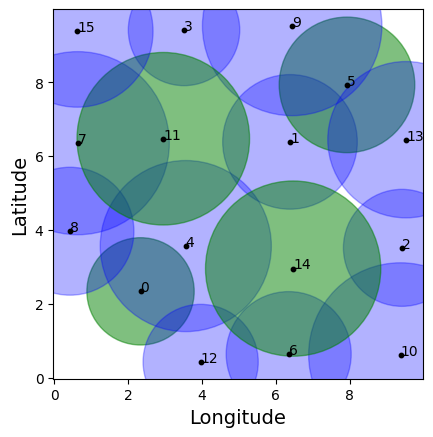

In [64]:
plot_antennas(data, status=bit_string_list[0]) #TODO: iterate over the elements of the proj meas